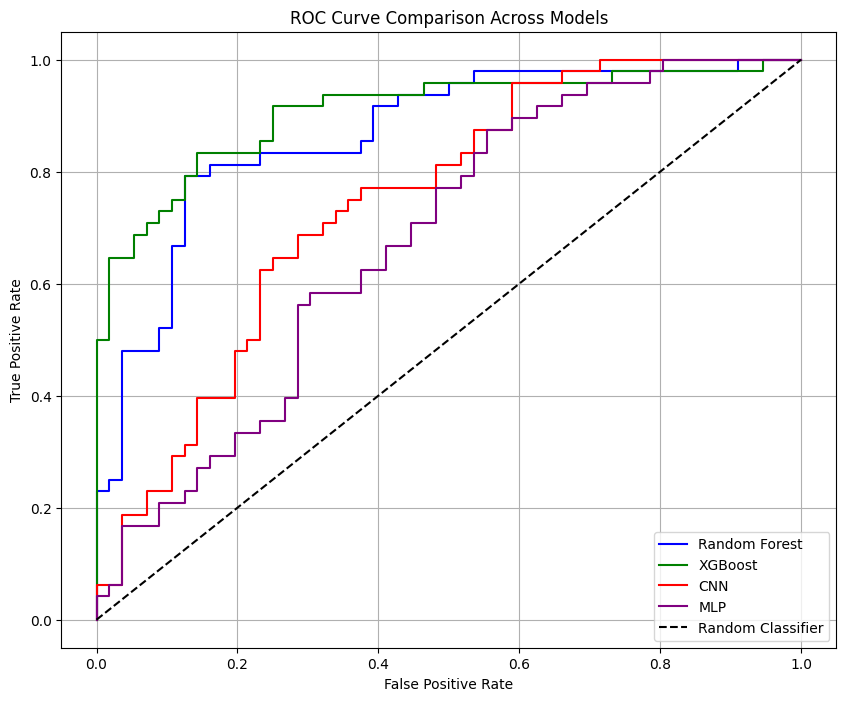

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Paths to data
data_folder = r"C:\Users\sejac\Desktop\BIEN471\csv_labels"
top_bins_path = r"C:\Users\sejac\Desktop\BIEN471\top_1000_bins_u_test.csv"

# Function to calculate z-scores
def calculate_z_scores(data):
    non_zero_data = data[data != 0]
    mean = non_zero_data.mean()
    std = non_zero_data.std()
    if std == 0:
        return np.zeros_like(data)
    z_scores = (data - mean) / std
    z_scores[data == 0] = 0
    return z_scores

# Load top 1000 bins
top_bins = pd.read_csv(top_bins_path)['Bin_ID']
all_patients_data = []

# Preprocess data
for filename in os.listdir(data_folder):
    if filename.endswith(".csv"):
        label = 1 if "_1_" in filename else 0
        patient_data = pd.read_csv(os.path.join(data_folder, filename))
        patient_data['Bin_ID'] = patient_data['Chromosome'] + ":" + patient_data['Start'].astype(str)
        patient_data = patient_data[patient_data['Bin_ID'].isin(top_bins)]
        if len(patient_data) != len(top_bins):
            continue
        patient_data['Percent_Methylation'] = calculate_z_scores(patient_data['Percent_Methylation'].values)
        patient_data = patient_data.set_index('Bin_ID')['Percent_Methylation']
        patient_data = patient_data.to_frame(name=filename).T
        patient_data['Label'] = label
        all_patients_data.append(patient_data)

# Combine into a single DataFrame
final_data = pd.concat(all_patients_data).reset_index(drop=True)
labels = final_data['Label']
features = final_data.drop('Label', axis=1)
features.fillna(features.mean(), inplace=True)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

# XGBoost
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

# CNN
class CancerClassifierCNN(nn.Module):
    def __init__(self, input_size):
        super(CancerClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(32 * (input_size // 4), 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

cnn_model = CancerClassifierCNN(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Train CNN
for epoch in range(10):
    cnn_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate CNN
cnn_model.eval()
y_proba_cnn = []
with torch.no_grad():
    for inputs, _ in DataLoader(test_dataset, batch_size=32):
        outputs = F.softmax(cnn_model(inputs), dim=1)[:, 1]
        y_proba_cnn.extend(outputs.numpy())
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_proba_cnn)
auc_cnn = roc_auc_score(y_test, y_proba_cnn)

# MLP
class CancerClassifierMLP(nn.Module):
    def __init__(self, input_size):
        super(CancerClassifierMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

mlp_model = CancerClassifierMLP(input_size=X_train.shape[1])
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

# Train MLP
for epoch in range(10):
    mlp_model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluate MLP
mlp_model.eval()
y_proba_mlp = []
with torch.no_grad():
    for inputs, _ in DataLoader(test_dataset, batch_size=32):
        outputs = F.softmax(mlp_model(inputs), dim=1)[:, 1]
        y_proba_mlp.extend(outputs.numpy())
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)
auc_mlp = roc_auc_score(y_test, y_proba_mlp)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost', color='green')
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN', color='red')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison Across Models')
plt.legend(loc='lower right')
plt.grid()
plt.show()
